In [180]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
from lib.scikitComponents import *
import itertools
import collections

# LDA

## Data preprocessing

Load all data, build a list of class labels using DMOZ top-level classes

In [278]:
# Load in the previously created corpus and dictionary of scraped sites
#dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')

Building new dictionary
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
Building new corpora
Done.


In [187]:
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))
# Build array of class labels
classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(dmoz_data['dmoz_categories'])
# Set up datasets
X = dmoz_data['meta']
y = classes

## Define a classification pipeline for the corpus data

The Pipeline() object chains together objects from the lib.scikitComponents file, so that they can be used as part of a scikit-learn classification pipeline

Define a classifier (decision trees), and chain the preprocessing step to the classifier

In [190]:
# classifier = sklearn.svm.LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0)

# classifier = sklearn.svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
# gamma=0.0, kernel='rbf', max_iter=-1, probability=False, random_state=None,
# shrinking=True, tol=0.001, verbose=False)

classifier = sklearn.ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)
# Use stem=True to remove word suffixes
builder = MetaMatrixBuilder()
clf = sklearn.pipeline.Pipeline([
    ('sanitiser', MetaSanitiser(stem=False, meta_selection_flags=7)),
    ('matrix_builder', builder),
    ('classification', classifier)])

## Run the classifier

We can use the meta corpus or the full body corpus here, just by replacing a single argument

The data is split in to training and test sets, and then fit to the training set. The LDA model is generated ***only*** from the training set, not the testing set.

In [191]:
scores = sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.35 (+/- 0.05)


In [192]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(np.array(X), classes)

## Do some analysis
### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some cases, indicating a moderate amount of success (given how naive this is!)

In [195]:
model = clf.fit(X_train, y_train)
print model.score(X_test, y_test)
predicted = model.predict(X_test)
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)

0.38
             precision    recall  f1-score   support

       arts       0.57      0.20      0.30        40
   business       0.54      0.35      0.42        55
  computers       0.51      0.38      0.44        52
      games       0.58      0.30      0.40        23
     health       0.29      0.21      0.24        34
       home       0.46      0.39      0.42        28
kids and teens       0.00      0.00      0.00        14
       news       0.45      0.24      0.32        37
 recreation       0.61      0.24      0.34        46
  reference       0.44      0.37      0.40        46
   regional       0.00      0.00      0.00         3
    science       0.58      0.40      0.47        53
   shopping       0.58      0.39      0.47        28
    society       0.42      0.11      0.18        44
     sports       0.27      0.85      0.41        97

avg / total       0.45      0.38      0.36       600



### Is there a correlation between test-set proportion and score?

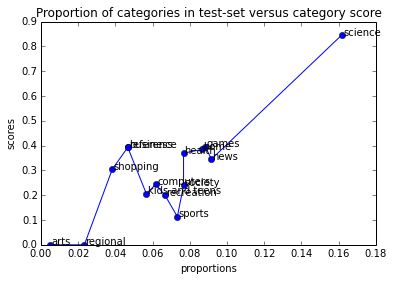

In [196]:
analysis.plot_proportion_investigation(predicted, dmoz_encoder, y_test)

### Which things get mistaken for other things?

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


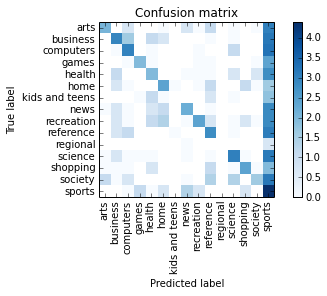

[[ 8  0  2  0  0  1  0  2  1  3  0  1  0  1 21]
 [ 0 19  5  0  3  2  0  0  0  1  0  1  0  0 24]
 [ 0  1 20  0  1  0  0  0  1  0  0  3  0  0 26]
 [ 0  0  1  7  1  0  0  0  1  1  0  0  0  1 11]
 [ 0  3  0  0  7  0  0  1  1  1  0  2  0  2 17]
 [ 0  2  1  0  0 11  1  0  1  3  0  0  3  1  5]
 [ 0  0  0  1  3  1  0  0  0  2  0  1  0  0  6]
 [ 1  2  1  0  2  3  0  9  0  1  0  0  0  0 18]
 [ 0  2  1  0  3  4  0  1 11  2  0  1  2  1 18]
 [ 0  2  3  0  0  0  1  0  0 17  0  1  0  0 22]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  2]
 [ 1  2  1  1  1  0  0  1  0  1  0 21  1  0 23]
 [ 1  1  1  0  2  0  0  0  0  3  0  1 11  1  7]
 [ 3  1  2  0  0  0  0  1  0  4  0  4  0  5 24]
 [ 0  0  1  3  1  2  0  4  2  0  0  0  2  0 82]]


In [197]:
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(np.log(cm), labels= dmoz_encoder.classes_)
plt.show()
print cm

## Searching over parameters using GridSearch...

Which combination of keywords, description and key phrases should we use? Let's check every combination!

- It seems that we want to use all three meta thingermabobs (flags = 7).
- The worst 'single' feature is *keyphrases*.
- Adding *keyphrases* to (*keywords*, *description*) adds only 0.001 accuracy


In [203]:
# Gridsearch
from sklearn.grid_search import GridSearchCV
param_grid = dict(sanitiser__meta_selection_flags=[1, 2, 3, 4, 5, 6, 7])
search = GridSearchCV(clf, param_grid=param_grid, verbose = 10)
search.fit(X, classes)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] sanitiser__meta_selection_flags=1 ...............................
[CV] ...... sanitiser__meta_selection_flags=1, score=0.293168 -   2.5s
[CV] sanitiser__meta_selection_flags=1 ...............................
[CV] ...... sanitiser__meta_selection_flags=1, score=0.289111 -   2.4s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    4.9s



[CV] sanitiser__meta_selection_flags=1 ...............................
[CV] ...... sanitiser__meta_selection_flags=1, score=0.278338 -   2.4s
[CV] sanitiser__meta_selection_flags=2 ...............................
[CV] ...... sanitiser__meta_selection_flags=2, score=0.213665 -   0.8s
[CV] sanitiser__meta_selection_flags=2 ...............................
[CV] ...... sanitiser__meta_selection_flags=2, score=0.225282 -   0.6s
[CV] sanitiser__meta_selection_flags=2 ...............................
[CV] ...... sanitiser__meta_selection_flags=2, score=0.212846 -   0.6s
[CV] sanitiser__meta_selection_flags=3 ...............................
[CV] ...... sanitiser__meta_selection_flags=3, score=0.286957 -   3.4s
[CV] sanitiser__meta_selection_flags=3 ...............................
[CV] ...... sanitiser__meta_selection_flags=3, score=0.291615 -   3.4s

[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done   8 jobs       | elapsed:   16.2s



[CV] sanitiser__meta_selection_flags=3 ...............................
[CV] ...... sanitiser__meta_selection_flags=3, score=0.279597 -   3.2s
[CV] sanitiser__meta_selection_flags=4 ...............................
[CV] ...... sanitiser__meta_selection_flags=4, score=0.294410 -   1.6s
[CV] sanitiser__meta_selection_flags=4 ...............................
[CV] ...... sanitiser__meta_selection_flags=4, score=0.284105 -   1.4s
[CV] sanitiser__meta_selection_flags=4 ...............................
[CV] ...... sanitiser__meta_selection_flags=4, score=0.272040 -   1.7s
[CV] sanitiser__meta_selection_flags=5 ...............................
[CV] ...... sanitiser__meta_selection_flags=5, score=0.327950 -   3.9s
[CV] sanitiser__meta_selection_flags=5 ...............................
[CV] ...... sanitiser__meta_selection_flags=5, score=0.357947 -   3.3s
[CV] sanitiser__meta_selection_flags=5 ...............................
[CV] ...... sanitiser__meta_selection_flags=5, score=0.329975 -   3.5s
[CV] 

[Parallel(n_jobs=1)]: Done  13 jobs       | elapsed:   28.0s
[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:   42.6s



[CV] sanitiser__meta_selection_flags=7 ...............................
[CV] ...... sanitiser__meta_selection_flags=7, score=0.327950 -   5.0s
[CV] sanitiser__meta_selection_flags=7 ...............................
[CV] ...... sanitiser__meta_selection_flags=7, score=0.350438 -   6.4s
[CV] sanitiser__meta_selection_flags=7 ...............................
[CV] ...... sanitiser__meta_selection_flags=7, score=0.335013 -   4.9s


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   58.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('sanitiser', MetaSanitiser(meta_selection_flags=7, stem=False)), ('matrix_builder', MetaMatrixBuilder(min_word_count=4)), ('classification', ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_n...estimators=100, n_jobs=4,
           oob_score=True, random_state=0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'sanitiser__meta_selection_flags': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=10)

In [204]:
print search.best_params_

{'sanitiser__meta_selection_flags': 5}


In [206]:
search.grid_scores_

[mean: 0.28691, std: 0.00626, params: {'sanitiser__meta_selection_flags': 1},
 mean: 0.21726, std: 0.00568, params: {'sanitiser__meta_selection_flags': 2},
 mean: 0.28607, std: 0.00495, params: {'sanitiser__meta_selection_flags': 3},
 mean: 0.28357, std: 0.00914, params: {'sanitiser__meta_selection_flags': 4},
 mean: 0.33862, std: 0.01369, params: {'sanitiser__meta_selection_flags': 5},
 mean: 0.31109, std: 0.00896, params: {'sanitiser__meta_selection_flags': 6},
 mean: 0.33778, std: 0.00939, params: {'sanitiser__meta_selection_flags': 7}]

In [277]:
trf = MetaSanitiser(stem=False, meta_selection_flags=7).fit_transform(X)
m = MetaMatrixBuilder(min_word_count=4)
count = collections.defaultdict(int)
for name, empty in zip(dmoz_encoder.inverse_transform(classes), np.sum(m.fit_transform(trf), axis=1)==0):
    count[name] += 1 if empty else 0
print "Number of documents with no metadata: {}".format(np.sum(np.sum(m.fit_transform(trf), axis=1)==0))
for x in count:
    print x, count[x]

Number of documents with no metadata: 859
arts 56
regional 4
shopping 20
business 53
reference 75
science 81
computers 89
recreation 47
kids and teens 20
sports 156
society 73
games 39
health 58
home 34
news 54
